## A life-cycle consumption model allowing for markov employment state and MA shocks

- author: Tao Wang
- date: Feb 2022
- this is a companion notebook to the paper "Perceived income risks"

- This notebook builds on a standard life-cycle consumption model with uninsured income risks and extends it to allow subjective beliefs about income risks
  - Preference/income process

      - CRRA utility 
      - During work: labor income risk: permanent + MA(1)/persistent/transitory/2-state Markov between UE and EMP or between low and high risk + i.i.d. unemployment shock
       -  a deterministic growth rate of permanent income over the life cycle 
      - During retirement: receives a constant pension proportional to permanent income (no permanent/transitory income risks)
      - A positive probability of death before terminal age 
  

In [1]:
import numpy as np
from interpolation import interp, mlinterp
from numba import njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from Utility import cal_ss_2markov,mean_preserving_spread
from copy import copy 

In [2]:
from resources_jit import MeanOneLogNormal as lognorm

In [3]:
## plot configuration 

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

## The Model Class and Solver

In [4]:
lc_data = [
    ## model paras
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Real interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent state  x
    ('z_val', float64[:]),       # values of z, grid values for the continuous (macro) persistent state    x
    ('sigma_psi', float64),      # permanent shock volatility              x
    ('sigma_eps', float64),      # transitory shock volatility
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-permanent income
    ('b_y', float64),            # loading of macro state to income        x 
    ('borrowing_cstr',boolean),  ## artificial borrowing constraint if True, natural borrowing constraint if False
    ('U',float64),               # the i.i.d. probability of being unemployed    * 
    ('sigma_psi_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transitory risk, only 2 for now
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('sigma_p_init',float64),         ## standard deviation of initial income
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('LivPrb',float64),         # the probability of being alive next period 
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('state_dependent_risk', boolean),     ## True if 2-state risks
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64),         ## zero: bequest thrown to the ocean; one: fully given to newborns
    ('theta',float64),           ## extrapolation parameter
    ## computational paras
    ('a_grid', float64[:]),      # Exogenous grid over savings
    ('eps_grid', float64[:]),    # Exogenous grid over transitory income shocks (for ma only)
    ('psi_shk_draws', float64[:]), ## draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # draws of MA/transitory income shocks 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('psi_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income
    ## regarding subjective beliefs
    ('P_sub',float64[:, :]),            # trans probs of belief states
    ('U2U_2mkv',float64[:]),            # state-dependent U2U prob
    ('E2E_2mkv',float64[:]),            # state-dependent E2E prob
    ('sigma_psi_true', float64),      # true permanent shock volatility              
    ('sigma_eps_true', float64),      # ture transitory shock volatility
    ('subjective',boolean),  ## belief is not necessarily equal to true 
    ('state_dependent_belief',boolean),  ## belief is state-dependent
    ('psi_shk_true_draws',float64[:]), ## draws of true permanent income shock 
    ('eps_shk_true_draws',float64[:]) ## draws of true transitory income shock 
]

In [5]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 1.0,     ## relative risk aversion  
                 β = 0.99,    ## discount factor
                 P = np.array([[0.9,0.1],
                              [0.2,0.8]]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,
                                   1.0]), ## markov state from low to high  
                 sigma_psi = 0.10,     ## size of permanent income shocks
                 sigma_eps = 0.10,   ## size of transitory income risks
                 x = 0.0,            ## MA(1) coefficient of non-permanent income shocks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 U = 0.0,   ## unemployment risk probability (0-1)
                 LivPrb = 0.995,       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 R = 1.02,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65 (including 65)
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 7,
                 grid_max = 5.0,
                 grid_size = 50,
                 ## subjective state dependent 
                 subjective = False,
                 state_dependent_belief = False,
                 P_sub = np.array([[0.5,0.5],
                              [0.5,0.5]]), 
                 sigma_psi_2mkv = np.array([0.05,0.2]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.08,0.12]),  ## transitory risks in 2 markov states
                 U2U_2mkv = np.array([0.05,0.1]),         ## U2U in low and high risk mkv state
                 E2E_2mkv = np.array([0.95,0.9]),         ## E2E in low and high risk mkv state
                 theta = 2,               ## asymmetric extrapolation parameter
                 unemp_insurance = 0.0,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 state_dependent_risk = False,
                 adjust_prob = 1.0,
                 sigma_p_init = 0.01,
                 init_b = 0.0,
                 λ = 0.0,
                 λ_SS = 0.0,
                 transfer = 0.0,
                 bequest_ratio = 0.0,
                 sigma_psi_true = 0.10,     ## true size of permanent income shocks
                 sigma_eps_true = 0.10     ## ture size of transitory income risks  
                ): 
        self.ρ, self.β = ρ, β
        self.R = R 
        self.W = W
        self.P, self.z_val = P, z_val
        self.U = U
        #assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.subjective = subjective 

        ###################################################
        ## fork depending on subjective or objective model ##
        #####################################################

        self.sigma_psi = sigma_psi
        self.sigma_eps = sigma_eps
            
        if self.subjective==False:
            self.sigma_psi_true = self.sigma_psi
            self.sigma_eps_true = self.sigma_eps
        else:
            print('reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!')
            self.sigma_psi_true = sigma_psi_true
            self.sigma_eps_true = sigma_eps_true
            
        self.x = x
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ_SS
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 
        self.sigma_psi_2mkv = sigma_psi_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        self.state_dependent_risk = state_dependent_risk
        
        ## belief 
        self.P_sub = P_sub
        self.state_dependent_belief = state_dependent_belief

            
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        self.prepare_shocks()
        
        ## saving a grid
        a_grid_regular = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size-1))
        self.a_grid = np.append(a_grid_regular,np.max(a_grid_regular)*100)
        
        ## ma(1) shock grid 
        if sigma_eps!=0.0 and x!=0.0:
            lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
            ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
            self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        else:
            self.eps_grid = np.array([0.0,0.001])  ## make two points for the c function to be saved correctly  

    
        ## extrapolation coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability (not needed if it is life-cycle)
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."  


    ## utility function 
    def u(self,c):
        if self.ρ!=1:
            return c**(1-self.ρ)/(1-ρ)
        elif self.ρ==1:
            return np.log(c)
    
    # marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)

    ## a function for the transitory/persistent income component
    ### the fork depending on if discrete-markov bool is on/off
    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to income
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            ## ump if z ==0 and emp if z==1
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)
        
    # a function from the log permanent shock to the income factor
    def Γ(self,psi_shk):
        return np.exp(psi_shk)
    
    
    def prepare_shocks(self):
        subjective = self.subjective
        shock_draw_size = self.shock_draw_size
        sigma_psi = self.sigma_psi
        sigma_eps = self.sigma_eps
        sigma_psi_true = self.sigma_psi_true
        sigma_eps_true = self.sigma_eps_true
        sigma_p_init = self.sigma_p_init
        sigma_psi_2mkv = self.sigma_psi_2mkv
        sigma_eps_2mkv = self.sigma_eps_2mkv
        
        ##################################################################
         ## discretized distributions 
        ##################################################################
                
        psi_shk_dist = lognorm(sigma_psi,100000,shock_draw_size)
        self.psi_shk_draws = np.log(psi_shk_dist.X)  ## the discretized is lognormal variable itself, we work with the log of it
        eps_shk_dist = lognorm(sigma_eps,100000,shock_draw_size)
        self.eps_shk_draws = np.log(eps_shk_dist.X)
        
        ## the draws used for simulation in household block 
        if subjective==False:
            self.psi_shk_true_draws =  self.psi_shk_draws
            self.eps_shk_true_draws =  self.eps_shk_draws
        else:
            psi_shk_true_dist = lognorm(sigma_psi_true,100000,shock_draw_size)
            eps_shk_true_dist = lognorm(sigma_eps_true,100000,shock_draw_size)
            self.psi_shk_true_draws =  np.log(psi_shk_true_dist.X)
            self.eps_shk_true_draws =  np.log(eps_shk_true_dist.X)
            
        
        init_p_dist = lognorm(sigma_p_init,100000,shock_draw_size)
        self.init_p_draws = np.log(init_p_dist.X)
        
        ## draw shocks for various markov state of volatility 
        #sigma_psi_2mkv_r = sigma_psi_2mkv.reshape(n_mkv,-1)
        #sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        sigma_psi_2mkv_l = lognorm(sigma_psi_2mkv[0],100000,shock_draw_size)
        sigma_psi_2mkv_h = lognorm(sigma_psi_2mkv[1],100000,shock_draw_size)
        
        self.psi_shk_mkv_draws = np.stack((np.log(sigma_psi_2mkv_l.X),
                                         np.log(sigma_psi_2mkv_h.X)))
        
        sigma_eps_2mkv_l = lognorm(sigma_eps_2mkv[0],100000,shock_draw_size)
        sigma_eps_2mkv_h = lognorm(sigma_eps_2mkv[1],100000,shock_draw_size)
        
        self.eps_shk_mkv_draws = np.stack((np.log(sigma_eps_2mkv_l.X),
                                         np.log(sigma_eps_2mkv_h.X)))
        
        
    def terminal_solution(self):
        
        k = len(self.a_grid)
        k2 =len(self.eps_grid)
        n = len(self.P)
        σ_init = np.empty((k,k2,n))
        m_init = np.empty((k,k2,n))
        
        for z in range(n):
            for j in range(k2):
                m_init[:,j,z] = self.a_grid
                σ_init[:,j,z] = m_init[:,j,z]
        return m_init,σ_init

In [6]:
## This function takes the consumption values at different 
## grids of state variables from period t+1, and
## the model class, then generates the consumption values at t.
## It depends on the age t since the income is different before 
## after the retirement. 

@njit
def EGM_combine(mϵ_in,
        σ_in,
        age_id, ## the period id for which the c policy is computed, the first period age_id=0, last period age_id=L-1, retirement after age_id=T-1
        lc):
    """
    The Coleman--Reffett operator for the life-cycle consumption problem,
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * mϵ_in is the same sized grid points of the three state variable 
        * mϵ_in[:,j,z] is the vector of wealth grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """    
    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    ρ, β = lc.ρ, lc.β
    R = lc.R

    ## markov state
    P = lc.P
    W = lc.W
    z_val = lc.z_val
    a_grid,eps_grid = lc.a_grid,lc.eps_grid
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws
    psi_shk_mkv_draws, eps_shk_mkv_draws = lc.psi_shk_mkv_draws, lc.eps_shk_mkv_draws
    borrowing_cstr = lc.borrowing_cstr 
    ue_prob = lc.U  ## uemp prob
    LivProb = lc.LivPrb  ## live probability
    unemp_insurance = lc.unemp_insurance
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability
     
    Y = lc.Y
    ####################
    Γ = lc.Γ
    ####################################
    G = lc.G[age_id+1]  ## get the age specific growth rate, G[T] is the sudden drop in retirement from working age
    ####################################

    x = lc.x
    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    pension = lc.pension
    ###################
    
    n = len(P)
    

    # Create consumption functions by linear interpolation
    ########################################################
    σ = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (m,ϵ)) 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_a X grid_size_ϵ X grid_size_z

    # Obtain c_i at each a_i, z, store in σ_out[i, z], computing
    # the expectation term by computed by averaging over discretized equally probable points of the distributions
    for i, a in enumerate(a_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ########################################
                    if lc.state_dependent_risk == False:
                        pass
                    else:
                        psi_shk_draws = psi_shk_mkv_draws[z_hat,:]
                        eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                    ########################################
                    for eps_shk in eps_shk_draws:
                        for psi_shk in psi_shk_draws:
                            ## for employed next period 
                            Γ_hat = Γ(psi_shk) 
                            u_shk = x*eps+eps_shk
                            age = age_id + 1
                            if age <=lc.T-1:   #till say 39, because consumption policy for t=40 changes   
                                ## work 
                                Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_u = σ(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                            
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                           ue_prob*utility_u* P[z, z_hat]
                                          )
                            else:
                                ## retirement
                                Y_R = pension
                                ## no income shocks affecting individuals
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat = σ(R/(G*Γ_hat) * a + (Y_R+transfer),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                            
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <1.0:
                    σ_out[i, j, z] =  adjust_prob/(1-LivProb*β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    mϵ_out = np.empty_like(σ_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            mϵ_out[:,j,z] = a_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                mϵ_out[0,j,z] = 0.0
            else:
                if age <=lc.T-1:
                    σ_out[0,j,z] = 0.0
                    ## the lowest transitory draw at state z  
                    if lc.state_dependent_belief:
                        self_min_a = - np.exp(np.min(eps_shk_mkv_draws[z,:]))*G/R 
                    else:
                        self_min_a = - np.exp(np.min(eps_shk_draws))*G/R

                    self_min_a = min(self_min_a,-unemp_insurance/R)
                    mϵ_out[0,j,z] = self_min_a
                else:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - pension*G/R
                    mϵ_out[0,j,z] = self_min_a

    return mϵ_out, σ_out

In [7]:
## this function describes asymmetric extrapolation rule from realized income shock to the perceived risk

@njit
def extrapolate(theta,
                x,
                eps_shk):
    """
    extrapolation function from realized eps_shk from unbiased risk x to the subjective risk x_sub
    x_sub = x when eps_shk = 0  
    theta governs the degree of extrapolation 
    """
    if x ==0.0:
        alpha=0.0
    else:
        alpha=np.log((1-x)/x) ## get the alpha for unbiased x
    x_sub = 1/(1+np.exp(alpha-theta*eps_shk))
    return x_sub

In [8]:
## subjective agent
### transitory shock affects risk perceptions

@njit
def EGM_br(mϵ_in, 
         σ_in, 
         age_id,
         lc):
    """
    UNDER BOUNDED RATIONALITY assumption
    The Coleman--Reffett operator for the life-cycle consumption problem. 
    using the endogenous grid method.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * mϵ_in is the same sized grid points of the three state variable 
        * mϵ_in[:,j,z] is the vector of asset grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at aϵ_in[i,j,z]
    """

    # Simplify names
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    R, ρ, P, β = lc.R, lc.ρ, lc.P, lc.β
    z_val = lc.z_val
    a_grid,eps_grid = lc.a_grid,lc.eps_grid
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws
    borrowing_cstr = lc.borrowing_cstr
    ue_prob = lc.U  ## uemp prob
    unemp_insurance = lc.unemp_insurance
    LivProb = lc.LivPrb  ## live probabilituy
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability
    Y = lc.Y
    ####################
    ρ = lc.ρ
    Γ = lc.Γ
    ####################################
    G = lc.G[age_id+1]   ## get the age specific 
    ####################################  
    x = lc.x
    λ = lc.λ
    transfer = lc.transfer
    pension = lc.pension
    
    ###################
    T = lc.T
    age = age_id+1
    ###################
    theta = lc.theta 
    sigma_eps = lc.sigma_eps
    eps_mean = -sigma_eps**2/2
    ###################
    
    n = len(P)

    # Create consumption function by linear interpolation
    ########################################################
    σ = lambda a,ϵ,z: mlinterp((mϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (a,ϵ)) 
    ########## need to replace with multiinterp 

    # Allocate memory
    σ_out = np.empty_like(σ_in)  ## grid_size_s X grid_size_ϵ X grid_size_z

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, a in enumerate(a_grid):
        for j, eps in enumerate(eps_grid):
            ##############################################################
            #x_sj = extrapolate(theta,
            #                   lc.x,
            #                   eps-eps_mean) ## sj: subjective 
            sigma_eps_sj = 0.05*np.sqrt((eps-eps_mean)**2)+0.95*lc.sigma_eps
            
            eps_shk_dist_sj= lognorm(sigma_eps_sj,100000,len(eps_shk_draws))
            eps_shk_draws_sj = np.log(eps_shk_dist_sj.X)
            #np.random.seed(166789)
            #eps_shk_draws_sj = sigma_eps_sj*np.random.randn(lc.shock_draw_size)-sigma_eps_sj**2/2
            #############################################################
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ################################
                    for eps_shk in eps_shk_draws_sj:
                        ############################
                        for psi_shk in psi_shk_draws:
                            Γ_hat = Γ(psi_shk) 
                            ###############
                            u_shk = x*eps+eps_shk
                            ####################
                            if age <=lc.T-1:
                                # work  
                                Y_hat = (1-λ)*Y(z_val_hat,u_shk) ## conditional on being employed 
                                c_hat = σ(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                c_hat_u = σ(R/(G*Γ_hat) * a + Y_hat_u+transfer ,eps_shk,z_hat)
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                               ue_prob*utility_u* P[z, z_hat]
                                              )
                            else:
                                
                                ## retirement
                                Y_R = lc.pension
                                ## no income shocks affecting individuals
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat = σ(R/(G*Γ_hat) * a + (Y_R+transfer),eps_shk,z_hat)
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws_sj))
                ## the last step depends on if adjustment is fully flexible
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <=1.0:
                    σ_out[i, j, z] =  adjust_prob/(1-β*R*(1-adjust_prob))*u_prime_inv(β * R* Ez)

    # Calculate endogenous asset grid
    mϵ_out = np.empty_like(σ_out)
            
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            mϵ_out[:,j,z] = a_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                mϵ_out[0,j,z] = 0.0
            #elif borrowing_cstr==True or ue_markov==True:
            #    σ_out[0,j,z] = 0.0
            #    mϵ_out[0,j,z] = min(0.0,-unemp_insurance/R)
            else:
                if age <=T-1:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - np.exp(np.min(eps_shk_draws_sj))*G/R
                    self_min_a = min(self_min_a,-unemp_insurance/R)
                    mϵ_out[0,j,z] = self_min_a
                else:
                    σ_out[0,j,z] = 0.0
                    self_min_a = - pension*G/R
                    mϵ_out[0,j,z] = self_min_a

    return mϵ_out, σ_out

In [9]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter(model,        # Class with model information
                              mϵ_vec,        # Initial condition for assets and MA shocks
                              σ_vec,        # Initial condition for consumption
                              br = False):

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 = σ_vec.shape[1]
    n_z = len(model.P)                       
    mϵs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    σs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    
    mϵs_new[0,:,:,:] = mϵ_vec
    σs_new[0,:,:,:] = σ_vec
    
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        #print("at work age of "+str(age))
        mϵ_vec_next, σ_vec_next = mϵs_new[year2L-1,:,:,:],σs_new[year2L-1,:,:,:]
        if br==False:
            mϵ_new, σ_new = EGM_combine(mϵ_vec_next, σ_vec_next, age_id, model)
        elif br==True:
            #print('subjective model with stochastic risk')
            mϵ_new, σ_new = EGM_br(mϵ_vec_next, σ_vec_next, age_id, model)
        mϵs_new[year2L,:,:,:] = mϵ_new
        σs_new[year2L,:,:,:] = σ_new

    return mϵs_new, σs_new

In [10]:
## for infinite horizon problem 
def solve_model_iter(model,        # Class with model information
                     me_vec,        # Initial condition for assets and MA shocks
                     σ_vec,        # Initial condition for consumption
                      tol=1e-6,
                      max_iter=2000,
                      verbose=True,
                      print_skip=50,
                      br = False):

    # Set up loop
    i = 0
    error = tol + 1

    ## memories for life-cycle solutions
    while i < max_iter and error > tol:
        if br==False:
                me_new, σ_new = EGM_combine(me_vec, σ_vec, 0,model)
        elif br==True:
            #print('subjective model with stochastic risk')
            mϵ_new, σ_new = EGM_br(me_vec, σ_vec, 0, model)

        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        me_vec, σ_vec = np.copy(me_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return me_vec, σ_vec

In [11]:
# a function to compare two solutions 

def compare_2solutions(ms_stars,
                      σs_stars):
    """
    input
    ======
    ms_stars: list of m grids
    σs_stars: list of c policies 
    
    output
    ======
    diff12: difference between solution 1 and solution 2 (1 minus 2)
    
    """
    if len(σs_stars)!=2 or len(σs_stars)!=2:
        print('only the first two solutions are compared!')
    m_star1, σ_star1 =ms_stars[0],σs_stars[0]
    m_star2, σ_star2 =ms_stars[1],σs_stars[1]

    ## get the interpolated c funcs
    c_stars1 = np.empty_like(σ_star1)
    c_stars2 = np.empty_like(σ_star2)
    n_age,n_m,n_eps,n_z = c_stars1.shape
    
    m_grid = np.linspace(0.0,5.0,n_m)
    
    for i in range(n_age):
        for j in range(n_eps):
            for k in range(n_z):
                c_func1 = lambda m: interp(m_star1[i,:,j,k],σ_star1[i,:,j,k],m)
                c_stars1[i,:,j,k] = c_func1(m_grid)
                c_func2 = lambda m: interp(m_star2[i,:,j,k],σ_star2[i,:,j,k],m)
                c_stars2[i,:,j,k] = c_func2(m_grid)
        
    diff12 = c_stars1-c_stars2
    return diff12 

## Initialize the model

In [12]:
if __name__ == "__main__":


    ## parameters 
    ###################

    U = 0.2 ## transitory ue risk
    U0 = 0.0 ## transitory ue risk

    ## life cycle 

    T = 40
    L = 60
    G = np.ones(L)
    YPath = np.cumprod(G)

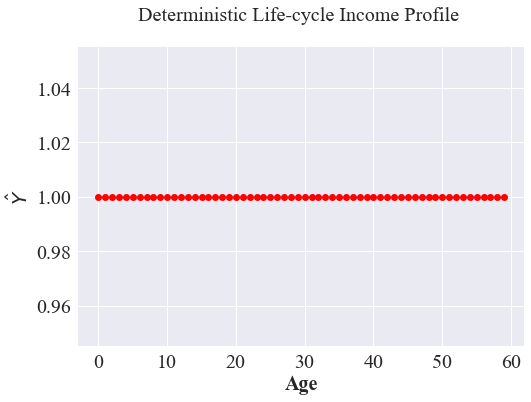

In [13]:
## a deterministic income profile 
if __name__ == "__main__":

    plt.title('Deterministic Life-cycle Income Profile \n')
    plt.plot(YPath,'ro')
    plt.xlabel('Age')
    plt.ylabel(r'$\hat Y$')

## Life-Cycle Problem 

In [14]:
if __name__ == "__main__":
    lc_paras = {'sigma_psi':0.15, # permanent 
                'sigma_eps': 0.0, #transitory
                'U':U,
                'ρ':2,
                'R':1.01,
                'T':T,
                'L':L,
                'G':G,
                'β':0.97,
                'x':0.0,  # no MA shock 
                'borrowing_cstr':True,
                'b_y':0.0, #no persistent state
                'unemp_insurance':0.15}

In [15]:
if __name__ == "__main__":
    lc = LifeCycle(**lc_paras)

### Consumption  the last period 

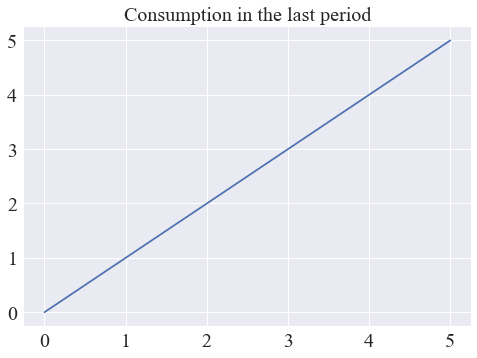

In [16]:
# Initial the end-of-period consumption policy of σ = consume all assets

if __name__ == "__main__":

    ## initial consumption functions 
    
    m_init,σ_init = lc.terminal_solution()
    
    plt.title('Consumption in the last period')
    plt.plot(m_init[0:-1,0,1],
             σ_init[0:-1,0,1])

In [17]:
if __name__ == "__main__":

    t_start = time()

  
    
    ### this line is very important!!!!
    #### need to regenerate shock draws for new sigmas
    lc.prepare_shocks()

    ## terminal solution
    m_init,σ_init = lc.terminal_solution()

    ## solve backward
    ms_star_basic, σs_star_basic = solve_model_backward_iter(lc,
                                                 m_init,
                                                 σ_init)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 2.521422863006592


### Different permanent/transitory risk (no MA)

In [18]:
if __name__ == "__main__":
    lc_pt_paras = copy(lc_paras)
    
    lc_pt = LifeCycle(**lc_pt_paras)

In [19]:
if __name__ == "__main__":

    t_start = time()

    sigma_psi_ls = [0.03,0.2]
    sigma_eps_ls = [0.03,0.2]
    
    ms_stars =[]
    σs_stars = []
    for i,sigma_psi in enumerate(sigma_psi_ls):
        lc_pt.sigma_psi = sigma_psi
        lc_pt.sigma_eps = sigma_eps_ls[i]
        ### this line is very important!!!!
        #### need to regenerate shock draws for new sigmas
        lc_pt.prepare_shocks()
        
        ## terminal solution
        m_init,σ_init = lc_pt.terminal_solution()
        
        ## solve backward
        ms_star, σs_star = solve_model_backward_iter(lc_pt,
                                                     m_init,
                                                     σ_init)
        ms_stars.append(ms_star)
        σs_stars.append(σs_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 2.4859139919281006


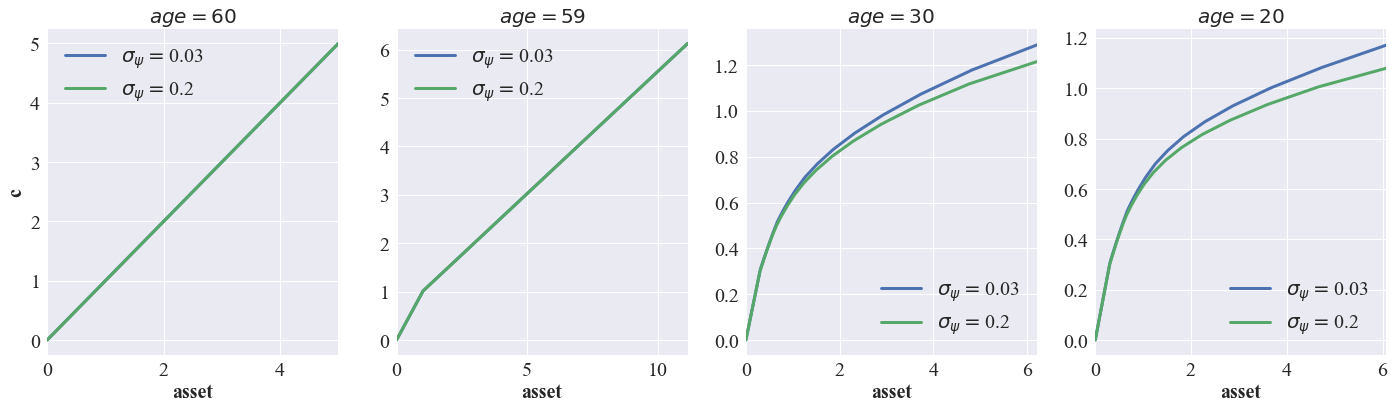

In [20]:
if __name__ == "__main__":


    ## plot c func at different age /asset grid
    years_left = [0,1,30,40]

    n_sub = len(years_left)

    eps_fix = 0 ## the first eps grid 

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_pt.L-year
        i = lc_pt.L-age
        for k,sigma_psi in enumerate(sigma_psi_ls):
            m_plt,c_plt = ms_stars[k][i,0:-1,eps_fix,0],σs_stars[k][i,0:-1,eps_fix,0]
            axes[x].plot(m_plt,
                         c_plt,
                         label = r'$\sigma_\psi=$'+str(sigma_psi),
                         lw=3,
                        )
        axes[x].legend()
        axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'$age={}$'.format(age))

In [21]:
## the size of consumption function is  T x nb_a x nb_eps x nb_z 
if __name__ == "__main__":
    print(σs_star.shape)

(60, 51, 2, 2)


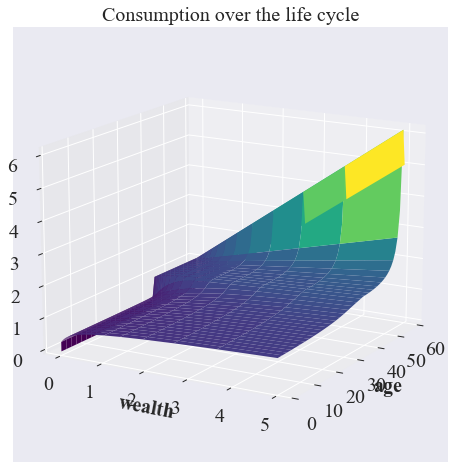

In [22]:
if __name__ == "__main__":

    ## plot 3d functions over life cycle 

    ages = np.array(range(ms_star.shape[0]))
    asset = ms_star[0,0:-1,0,0]
    xx, yy = np.meshgrid(ages, asset)
    c_stars = np.flip(σs_star[:,0:-1,0,0],axis=0).T

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, 
                         projection='3d')
    dem3d = ax.plot_surface(xx,
                            yy,
                            c_stars,
                            cmap="viridis"
                           )
    ax.set_xlim(60,0)
    ax.set_title('Consumption over the life cycle')
    ax.set_xlabel('age')
    ax.set_ylabel('wealth')
    ax.view_init(15, 30)

### With a Markov/persistent state: good versus bad 

In [23]:
if __name__ == "__main__":
    lc_ar_paras = copy(lc_paras)
    lc_ar_paras['b_y'] = 0.5
    ## initialize another 
    lc_ar = LifeCycle(**lc_ar_paras)

In [24]:
if __name__ == "__main__":


    ## solve the model for different persistence 
    t_start = time()
    
    P = np.array([(0.8, 0.2),
                  (0.05, 0.95)])
    
    P_ls = [P]
    
    ms_stars_ar = []
    σs_stars_ar = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        
        lc_ar.P = P
        ## no need to reinitialize the model because P is only used in solving stage

        ## terminal solution
        m_init_ar,σ_init_ar = lc_ar.terminal_solution()

    
        ## solve the model 
        ms_star_ar, σs_star_ar = solve_model_backward_iter(lc_ar,
                                                         m_init_ar,
                                                         σ_init_ar)
        ms_stars_ar.append(ms_star_ar)
        σs_stars_ar.append(σs_star_ar)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 0.049391984939575195


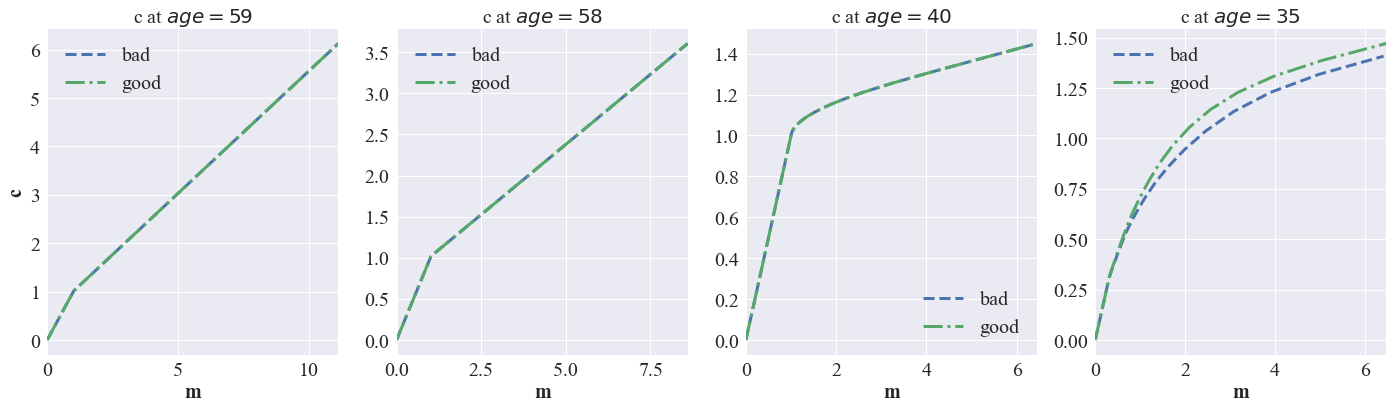

In [25]:
if __name__ == "__main__":


    ## compare two markov states good versus bad 

    years_left = [1,2,20,25]

    n_sub = len(years_left)


    eps_ls = [0]

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_ar.L-year
        i = lc_ar.L-age
        for eps in eps_ls:
            m_plt_l,c_plt_l = ms_stars_ar[0][i,0:-1,eps,0],σs_stars_ar[0][i,0:-1,eps,0]
            m_plt_h,c_plt_h  = ms_stars_ar[0][i,0:-1,eps,1],σs_stars_ar[0][i,0:-1,eps,1]
            axes[x].plot(m_plt_l,
                         c_plt_l,
                         '--',
                         label ='bad',
                         lw=3)
            axes[x].plot(m_plt_h,
                         c_plt_h,
                         '-.',
                         label ='good',
                         lw=3)
        axes[x].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_h)))
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c at $age={}$'.format(age))

### State-dependent risks 

In [26]:
if __name__ == "__main__":

    ## transition matrix between low and high risk state

    P = np.array([(0.5, 0.5),
                  (0.5, 0.5)])   # markov transition matrices

    ss_P = cal_ss_2markov(P)
    prob_l = P[0,0]
    prob_h = P[0,1]

    ## keep average risks the same 
     
    sigma_psi_2mkv = np.sqrt(
        mean_preserving_spread(
            mean = lc.sigma_psi**2,
            probs = np.array([prob_l,prob_h]),
            l2mean_ratio = 0.01)
    )
    
    
    
    sigma_eps_2mkv = np.sqrt(
        mean_preserving_spread(
            mean = lc.sigma_eps**2,
            probs = np.array([prob_l,prob_h]),
            l2mean_ratio = 0.01)
    )

    b_y = 0.0  ## set the macro state loading to be zero, i.e. only risks differ across two states

In [27]:
if __name__ == "__main__":
    ## compute steady state 
    av_sigma_psi = np.sqrt(np.dot(P[0,:],sigma_psi_2mkv**2))
    av_sigma_eps = np.sqrt(np.dot(P[0,:],sigma_eps_2mkv**2))
    print('steady state is '+str(ss_P))
    print('transitory probability is '+str(P[0,:]))
    print('average permanent risk is '+str(av_sigma_psi)+' compared to objective model '+str(lc.sigma_psi))
    print('average transitory risk is '+str(av_sigma_eps)+' compared to objective model '+str(lc.sigma_eps))

steady state is [0.5 0.5]
transitory probability is [0.5 0.5]
average permanent risk is 0.15 compared to objective model 0.15
average transitory risk is 0.0 compared to objective model 0.0


In [28]:
if __name__ == "__main__":

    print('permanent risk state is '+str(sigma_psi_2mkv))
    print('transitory risk state is '+str(sigma_eps_2mkv))

permanent risk state is [0.015      0.21160104]
transitory risk state is [0. 0.]


In [29]:
if __name__ == "__main__":

    ## another model instance 
    lc_sv_paras = copy(lc_paras)
    lc_sv_paras['sigma_psi_2mkv'] = sigma_psi_2mkv
    lc_sv_paras['sigma_eps_2mkv'] = sigma_eps_2mkv
    lc_sv_paras['state_dependent_risk'] = True

    lc_sv0 = LifeCycle(**lc_sv_paras)

In [30]:
if __name__ == "__main__":

    ## solve the model for different transition matricies 

    t_start = time()

    P_ls = [P]
    ms_stars_sv = []
    σs_stars_sv = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_sv0.P = P

        ## terminal solution       
        m_init_sv,σ_init_sv = lc_sv0.terminal_solution()

        ## solve the model 
        ms_star_sv, σs_star_sv = solve_model_backward_iter(lc_sv0,
                                                           m_init_sv,
                                                           σ_init_sv)
        ms_stars_sv.append(ms_star_sv)
        σs_stars_sv.append(σs_star_sv)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 0.025336742401123047


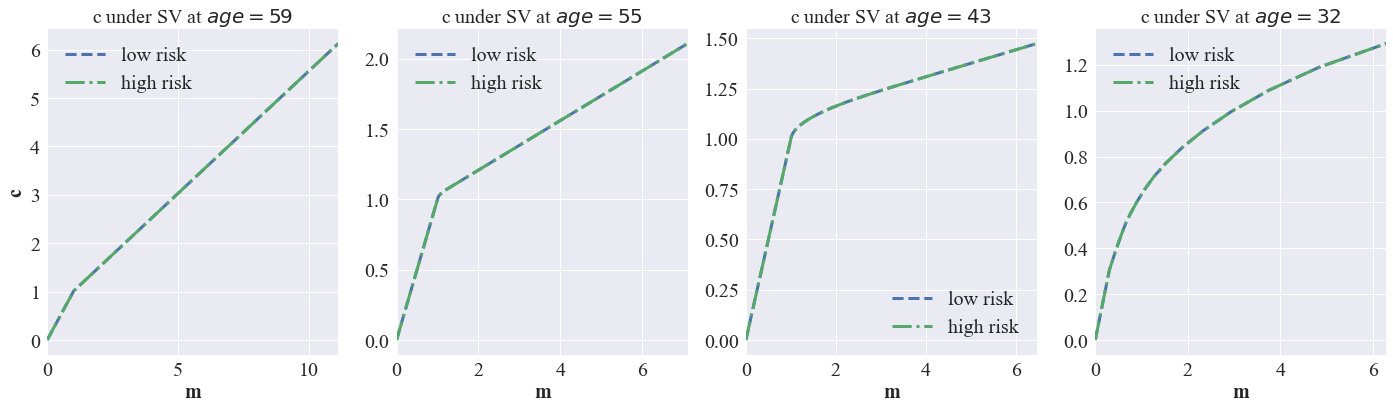

In [31]:
if __name__ == "__main__":
    ## compare two markov states low versus high risk 

    years_left = [1,5,17,28]

    n_sub = len(years_left)

    eps_id = 0

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        m_plt_l,c_plt_l = ms_stars_sv[0][i,0:-1,eps_id,0],σs_stars_sv[0][i,0:-1,eps_id,0]
        m_plt_h,c_plt_h = ms_stars_sv[0][i,0:-1,eps_id,1],σs_stars_sv[0][i,0:-1,eps_id,1]
        
        axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='low risk',
                     lw=3)
        
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                     c_plt_h,
                     '-.',
                     label ='high risk',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_h)))

        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under SV at $age={}$'.format(age))

### Comparison: objective and subjective risk perceptions

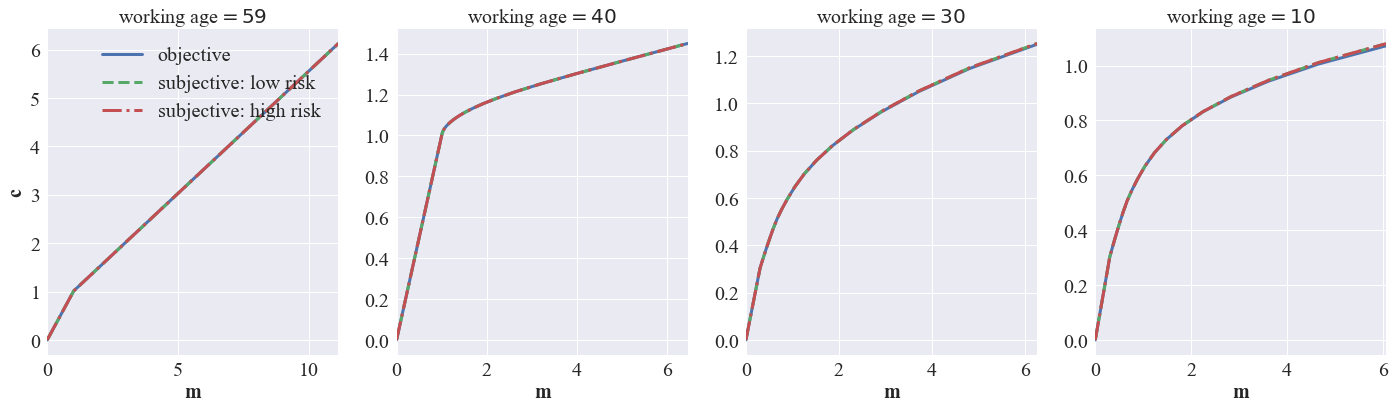

In [32]:
if __name__ == "__main__":


    ## compare subjective and objective models 
    years_left = [1,20,30,50]


    n_sub = len(years_left)

    eps_fix = 0

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age

        ## baseline: no ma shock 
        m_plt,c_plt = ms_star_basic[i,0:-1,eps_fix,0],σs_star_basic[i,0:-1,eps_fix,0]
        axes[x].plot(m_plt,
                     c_plt,
                     label = 'objective',
                     lw=3)
     
         ## stochastic volatility 
        m_plt_l,c_plt_l = ms_stars_sv[0][i,0:-1,eps_fix,0],σs_stars_sv[0][i,0:-1,eps_fix,0]
        m_plt_h,c_plt_h = ms_stars_sv[0][i,0:-1,eps_fix,1],σs_stars_sv[0][i,0:-1,eps_fix,1]

        axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='subjective: low risk',
                     lw=3)
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                     c_plt_h,
                     '-.',
                     label ='subjective: high risk',
                     lw=3)

        axes[0].legend()
        axes[x].set_xlim((0.0,np.max(m_plt)))
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'working age$={}$'.format(age))

    fig.savefig('../Graphs/model/comparison1.png')

### With a Markov/persistent unemployment state

In [33]:
if __name__ == "__main__":


    ## transition matrix between emp and uemp

    ## transition probability during normal times of the economy 

    P_uemkv = np.array([(0.2, 0.8),
                        (0.2, 0.8)])   # markov transition matrices


In [34]:
if __name__ == "__main__":
    lc_uemkv_paras = copy(lc_paras)
    lc_uemkv_paras['ue_markov'] = True
    
    ## initialize another 
    lc_uemkv = LifeCycle(**lc_uemkv_paras)

In [35]:
if __name__ == "__main__":

    ## solve the model for different transition matrices of UE markov
    t_start = time()

    P_ls = [P_uemkv]
    ms_stars_uemkv=[]
    σs_stars_uemkv = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_uemkv.P = P

        ## terminal solution
        m_init_uemkv,σ_init_uemkv = lc_uemkv.terminal_solution()

        ## solve the model 
        ms_star_uemkv, σs_star_uemkv = solve_model_backward_iter(lc_uemkv,
                                                                 m_init_uemkv,
                                                                 σ_init_uemkv)
        ms_stars_uemkv.append(ms_star_uemkv)
        σs_stars_uemkv.append(σs_star_uemkv)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 0.025435924530029297


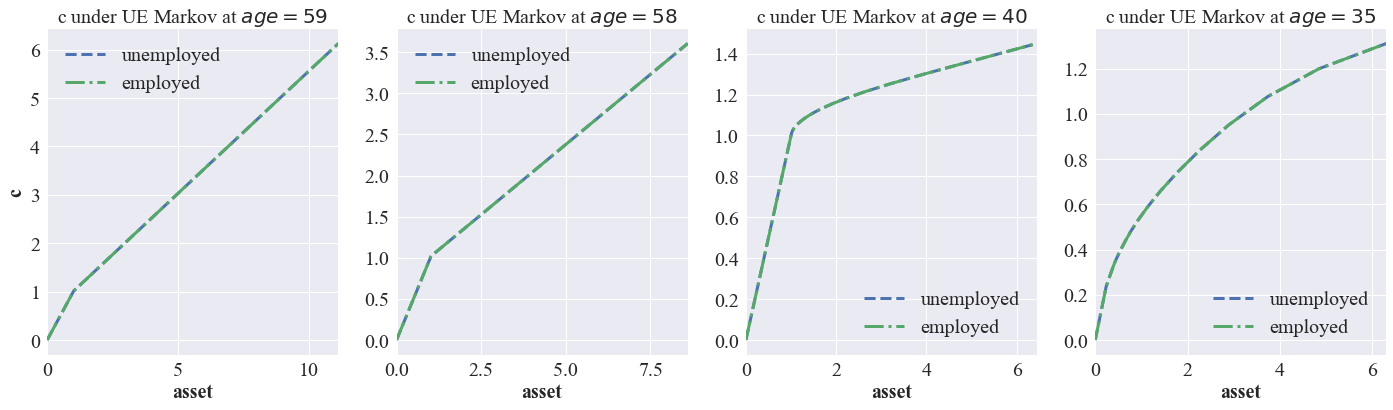

In [36]:
if __name__ == "__main__":


    ## compare two markov states of emp and uemp 

    years_left = [1,2,20,25]

    n_sub = len(years_left)

    eps_id = 0

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_uemkv.L-year
        i = lc_uemkv.L-age
        m_plt_u, c_plt_u = ms_stars_uemkv[0][i,0:-1,eps_id,0],σs_stars_uemkv[0][i,0:-1,eps_id,0]
        m_plt_e, c_plt_e = ms_stars_uemkv[0][i,0:-1,eps_id,1],σs_stars_uemkv[0][i,0:-1,eps_id,1]

        axes[x].plot(m_plt_u, ## 0 indicates the low risk state 
                     c_plt_u,
                     '--',
                     label ='unemployed',
                     lw=3)
        axes[x].plot(m_plt_e, ## 1 indicates the high risk state 
                     c_plt_e,
                     '-.',
                     label ='employed',
                     lw=3)
        axes[x].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_e)))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under UE Markov at $age={}$'.format(age))

### "Countercylical" risks

- unemployed perceive higher risks


In [37]:
if __name__ == "__main__":


    ss_P_cr= cal_ss_2markov(P_uemkv)
    prob_h_cr = P_uemkv[0,0]
    prob_l_cr = P_uemkv[0,1]

    ## keep average risks the same 
    ### notice here I put high risk at the first!!!
    sigma_psi_2mkv_cr = np.sqrt(mean_preserving_spread(mean = lc_uemkv.sigma_psi**2,
                                                      probs = np.array([prob_l_cr,prob_h_cr]),
                                                      l2mean_ratio = 0.1)
                               )
    ### notice here I put high risk at the first!!!
    sigma_psi_2mkv_cr = np.flip(sigma_psi_2mkv_cr)
    ### notice here I put high risk at the first!!!
    
    sigma_eps_2mkv_cr = np.sqrt(mean_preserving_spread(mean = lc_uemkv.sigma_eps**2,
                                                      probs = np.array([prob_l_cr,prob_h_cr]),
                                                      l2mean_ratio = 0.1)
                               )
    ### notice here I put high risk at the first!!!
    sigma_eps_2mkv_cr = np.flip(sigma_eps_2mkv_cr)
   ### notice here I put high risk at the first!!!


    ## again, zero loading from z
    b_y = 0.0

In [38]:
if __name__ == "__main__":
    ## compute steady state 
    av_sigma_psi_cr = np.sqrt(np.dot(P_uemkv[0,:],sigma_psi_2mkv_cr**2))
    av_sigma_eps_cr = np.sqrt(np.dot(P_uemkv[0,:],sigma_eps_2mkv_cr**2))
    print('steady state is '+str(ss_P_cr))
    print('transitory probability is '+str(P_uemkv[0,:]))

    print('average permanent risk is '+str(av_sigma_psi_cr)+' compared to objective model '+str(lc_uemkv.sigma_psi))
    print('average transitory risk is '+str(av_sigma_eps_cr)+' compared to objective model '+str(lc_uemkv.sigma_eps))

steady state is [0.2 0.8]
transitory probability is [0.2 0.8]
average permanent risk is 0.15 compared to objective model 0.15
average transitory risk is 0.0 compared to objective model 0.0


In [39]:
if __name__ == "__main__":

    lc_cr_paras = copy(lc_paras)
    lc_cr_paras['sigma_psi_2mkv'] = sigma_psi_2mkv_cr
    lc_cr_paras['sigma_eps_2mkv'] = sigma_eps_2mkv_cr
    lc_cr_paras['ue_markov'] = True
    lc_cr_paras['state_dependent_risk'] = True

    ## model instance 
    lc_cr= LifeCycle(**lc_cr_paras)

In [40]:
if __name__ == "__main__":


    ## solve the model for different transition matrices

    t_start = time()

    P_ls = [P_uemkv]
    ms_stars_cr=[]
    σs_stars_cr = []

    for i, P in enumerate(P_ls):

        ## feed the model with a markov matrix of macro state 
        lc_cr.P = P

        ## initial guess
        m_init_cr,σ_init_cr =lc_cr.terminal_solution()

        ## solve the model 
        ms_star_cr, σs_star_cr = solve_model_backward_iter(lc_cr,
                                                           m_init_cr,
                                                           σ_init_cr)
        ms_stars_cr.append(ms_star_cr)
        σs_stars_cr.append(σs_star_cr)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 0.02508687973022461


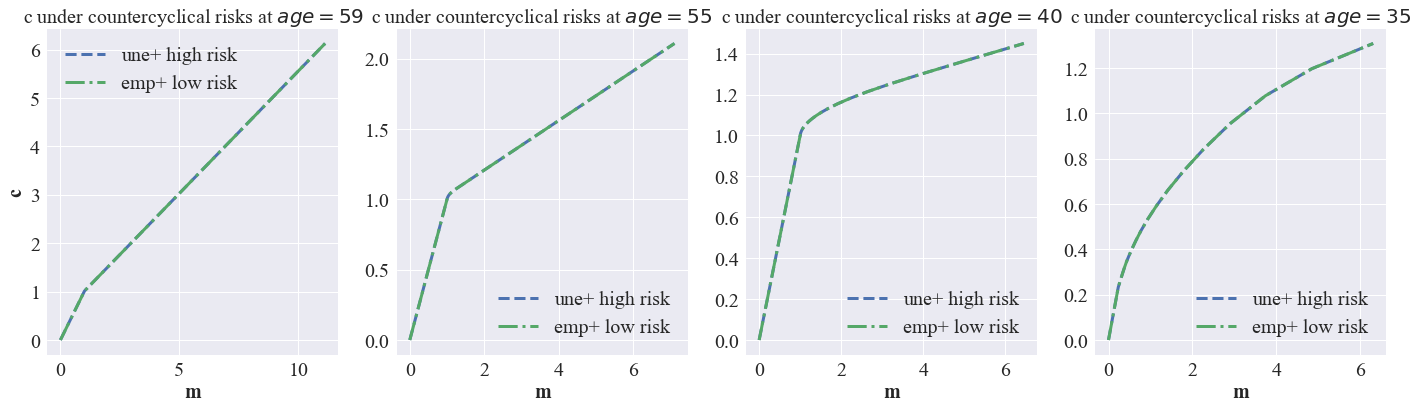

In [41]:
if __name__ == "__main__":


    ## compare two markov states low versus high risk 

    years_left = [1,5,20,25]

    n_sub = len(years_left)

    eps_id = 0

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        m_plt_l,c_plt_l = ms_stars_cr[0][i,0:-1,eps_id,0],σs_stars_cr[0][i,0:-1,eps_id,0]
        m_plt_h,c_plt_h = ms_stars_cr[0][i,0:-1,eps_id,1],σs_stars_cr[0][i,0:-1,eps_id,1]
        
        axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='une+ high risk',
                     lw = 3)
        axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                     c_plt_h,
                     '-.',
                     label ='emp+ low risk',
                     lw = 3)
        axes[x].legend()
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'c under countercyclical risks at $age={}$'.format(age))

### Objective and subject state-dependent profile

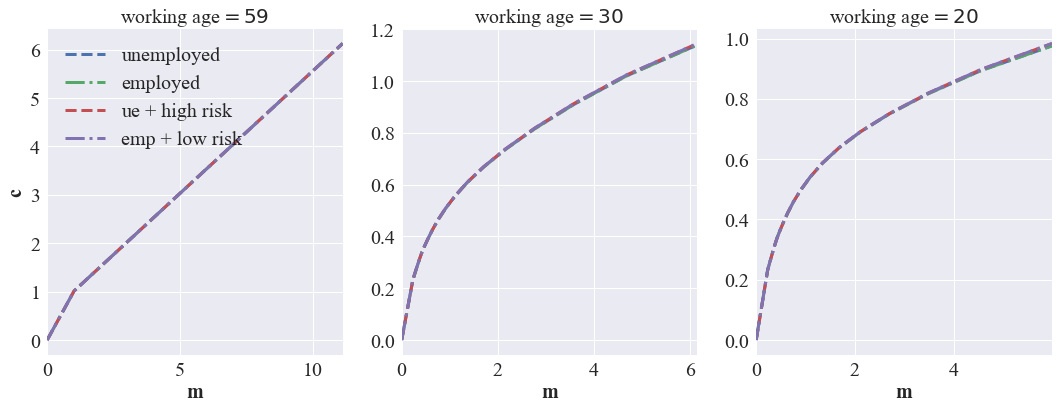

In [42]:
if __name__ == "__main__":

    ## compare subjective and objective models 

    years_left = [1,30,40]


    n_sub = len(years_left)

    eps_ls = [0]

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc.L-year
        i = lc.L-age
        for eps in eps_ls:
    
            ## persistent 
            m_plt_u, c_plt_u = ms_stars_uemkv[0][i,0:-1,eps,0],σs_stars_uemkv[0][i,0:-1,eps,0]
            m_plt_e, c_plt_e = ms_stars_uemkv[0][i,0:-1,eps,1],σs_stars_uemkv[0][i,0:-1,eps,1]
            axes[x].plot(m_plt_u,
                         c_plt_u,
                         '--',
                         label ='unemployed',
                         lw=3)
            axes[x].plot(m_plt_e,
                         c_plt_e,
                         '-.',
                         label ='employed',
                         lw=3)
            ## countercyclical 
            m_plt_l,c_plt_l = ms_stars_cr[0][i,0:-1,eps,0],σs_stars_cr[0][i,0:-1,eps,0]
            m_plt_h,c_plt_h = ms_stars_cr[0][i,0:-1,eps,1],σs_stars_cr[0][i,0:-1,eps,1]
            axes[x].plot(m_plt_l, ## 0 indicates the low risk state 
                     c_plt_l,
                     '--',
                     label ='ue + high risk',
                     lw=3)
            axes[x].plot(m_plt_h, ## 1 indicates the high risk state 
                         c_plt_h,
                         '-.',
                         label ='emp + low risk',
                         lw=3)
        axes[0].legend()
        axes[x].set_xlim((0.0,np.max(m_plt_e)))
        axes[x].set_xlabel('m')
        axes[0].set_ylabel('c')
        axes[x].set_title(r'working age$={}$'.format(age))

    #plt.suptitle('Various Straight Lines',fontsize=20)

    fig.savefig('../Graphs/model/comparison2.png')

## Infinite horizon problem

Error at iteration 50 is 0.1775522747452385.
Error at iteration 100 is 0.02866009780074208.
Error at iteration 150 is 0.006649861460074291.
Error at iteration 200 is 0.001669262239646585.
Error at iteration 250 is 0.00042726572657336703.
Error at iteration 300 is 0.00010990830679347141.
Error at iteration 350 is 2.830857231650441e-05.
Error at iteration 400 is 7.293707595223964e-06.
Error at iteration 450 is 1.8793841363162755e-06.

Converged in 474 iterations.
Time taken, in seconds: 0.2503480911254883


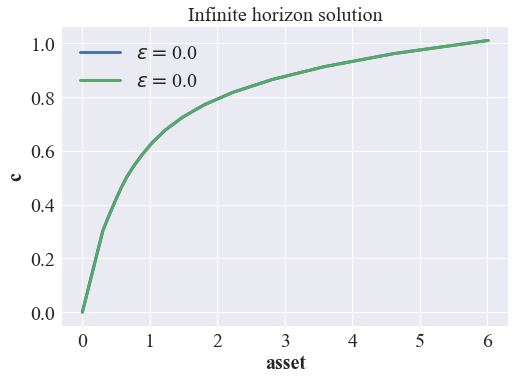

In [43]:
if __name__ == "__main__":
    
    inf_liv_paras = copy(lc_paras)
    
    
    ## initialize a model instance

    inf_liv = LifeCycle(**inf_liv_paras)


    ## initial guess of consumption functions 

    m_init,σ_init = inf_liv.terminal_solution()
   

    t_start = time()


    x_ls = [0.0]
    ms_inf_stars =[]
    σs_inf_stars = []
    for i,x in enumerate(x_ls):

        ## set different ma parameters 
        inf_liv.x = x
        m_inf_star, σ_inf_star = solve_model_iter(inf_liv,
                                                  m_init,
                                                  σ_init)
        ms_inf_stars.append(m_inf_star)
        σs_inf_stars.append(σ_inf_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   


    ## plot c func 

    eps_ls = [0,1]

    ms_inf_star = ms_inf_stars[0]
    σs_inf_star = σs_inf_stars[0]


    for eps in eps_ls:
        plt.plot(ms_inf_star[0:-1,eps,0],
                 σs_inf_star[0:-1,eps,0],
                 label = r'$\epsilon=$'+str(round(inf_liv.eps_grid[eps],2)),
                 lw=3
                )
        plt.legend()
        plt.xlabel('asset')
        plt.ylabel('c')
        plt.title('Infinite horizon solution')

## Infinite horizon with adjustment inertia



Error at iteration 50 is 0.20122652652902673.
Error at iteration 100 is 0.04777880497911102.
Error at iteration 150 is 0.019824738580508594.
Error at iteration 200 is 0.010164269903584433.
Error at iteration 250 is 0.0057836285714545355.
Error at iteration 300 is 0.0034866126786816665.
Error at iteration 350 is 0.00217490503107598.
Error at iteration 400 is 0.00138548830573626.
Error at iteration 450 is 0.0008943794762803492.
Error at iteration 500 is 0.0005822788515317256.
Error at iteration 550 is 0.0003811809111731179.
Error at iteration 600 is 0.00025043283609349487.
Error at iteration 650 is 0.00016492024769831914.
Error at iteration 700 is 0.00010877498953476561.
Error at iteration 750 is 7.181697692271172e-05.
Error at iteration 800 is 4.74479509948722e-05.
Error at iteration 850 is 3.136178763618602e-05.
Error at iteration 900 is 2.073536505342588e-05.
Error at iteration 950 is 1.3712191210935032e-05.
Error at iteration 1000 is 9.068966000391754e-06.
Error at iteration 1050 is 

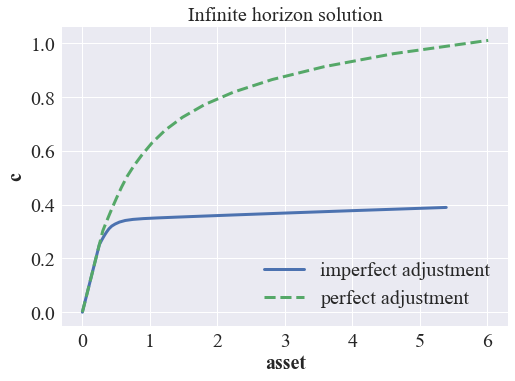

In [44]:
if __name__ == "__main__":


    ## Initialize a model instance
    imp_adjust_paras = copy(lc_paras)
    imp_adjust_paras['adjust_prob'] = 0.6
    
    imp_adjust = LifeCycle(**imp_adjust_paras)

    ## initial consumption functions 
    m_init,σ_init = imp_adjust.terminal_solution()

    t_start = time()

    x_ls = [0.0]
    ms_imp_stars =[]
    σs_imp_stars = []
    for i,x in enumerate(x_ls):

        ## set different ma parameters 
        inf_liv.x = x
        m_imp_star, σ_imp_star = solve_model_iter(imp_adjust,
                                                  m_init,
                                                  σ_init)
        ms_imp_stars.append(m_imp_star)
        σs_imp_stars.append(σ_imp_star)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   


    ## plot c func at different age /asset grid

    eps_ls = [0]

    ms_imp_star = ms_imp_stars[0]
    σs_imp_star = σs_imp_stars[0]

    for y,eps in enumerate(eps_ls):
        plt.plot(ms_imp_star[0:-1,eps,1],
                 σs_imp_star[0:-1,eps,1],
                 '-',
                 label = 'imperfect adjustment',
                 lw=3
                )
        plt.plot(ms_inf_star[0:-1,eps,1],
                 σs_inf_star[0:-1,eps,1],
                 '--',
                 label = 'perfect adjustment',
                 lw=3
                )
        plt.legend()
        plt.xlabel('asset')
        plt.ylabel('c')
        plt.title('Infinite horizon solution')